<a href="https://colab.research.google.com/github/scottspurlock/csc401-2021s/blob/main/tutorials/day06_tutorial_model_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 6 Tutorial
- Metrics (accuracy, precision, recall, error)
- Cross validation
- Grid search (hyperparameters)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns;
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [2]:
# This is the classic iris dataset (1936)
# Read more: https://archive.ics.uci.edu/ml/datasets/Iris
file_link = 'https://drive.google.com/uc?export=download&id=1UZTj2GjSTFiBqAeOXiroTxviy_zLxLpL'
df = pd.read_csv(file_link)
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
# Separate out data and labels
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = df['class'].astype('category').cat.codes.values
print('X shape:', X.shape, '   y shape:', y.shape)

X shape: (150, 4)    y shape: (150,)


In [4]:
# Split into train/test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
# Train a model
model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [6]:
# Predict test data
ypred = model.predict(Xtest)

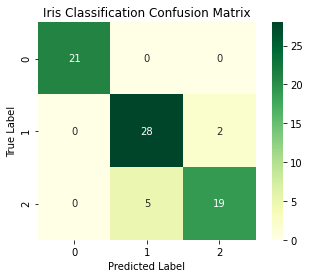

In [7]:
# Display confusion matrix
cm = confusion_matrix(ytest, ypred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGn",
                    xticklabels=model.classes_,
                    yticklabels=model.classes_)

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Iris Classification Confusion Matrix')
plt.show()

## Classification Report
It is often helpful to have more information than just accuracy to evaluate how well classification is working.
- Precision indicates how often the model was correct, when predicting a particular class.
- Recall indicates how often the model was correct, when the actual label was a particular class.
- f1-score is the harmonic mean of precision and recall.
- Support counts how many times a class occurs in the actual labels.

In [8]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.85      0.93      0.89        30
           2       0.90      0.79      0.84        24

    accuracy                           0.91        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



## Cross Validation
To reduce variability due to a particular random sample of train/test data, it's a good idea to run multiple experiments and average the results. A common approach is to use cross validation, where the data is partitioned into K sets (called folds), and K experiments are performed, each time with the Kth set being the test data (sometimes called the validation set), and the rest being the training data.

Most commonly, K is selected to be 5, and the testing procedure is called 5-fold cross validation. See figure below.

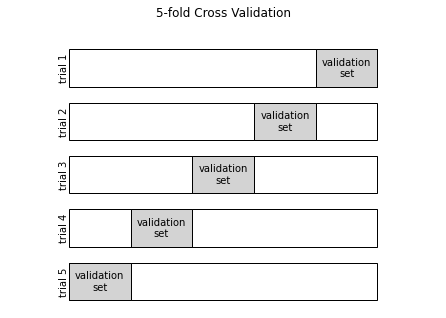

In [9]:
# Adapted from VanderPlas
def draw_rects(N, ax, textprop={}):
    for i in range(N):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='white', ec='black'))
        ax.add_patch(plt.Rectangle((5. * i / N, i), 5. / N, 0.7, fc='lightgray', ec='black'))
        ax.text(5. * (i + 0.5) / N, i + 0.35,
                "validation\nset", ha='center', va='center', **textprop)
        ax.text(0, i + 0.35, "trial {0}".format(N - i),
                ha='right', va='center', rotation=90, **textprop)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-0.2, N + 0.2)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(5, ax, textprop=dict(size=10))
plt.title('5-fold Cross Validation')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(model, X, y, cv=5)
results

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [11]:
print('Average accuracy: {:.2f}%'.format(100*results.mean()))

Average accuracy: 96.00%


## Grid search
Most machine learning methods have hyperparameters that must be set. The best values for the hyperparameters depend on the data, and need to be tuned through experimentation. Grid search is the process of trying out different settings. Note that this process can be extremely slow when datasets are large and/or there are many hyperparameters.

In [12]:
# For KNN, the main hyperparameter is K, the number of neighbors (in the training set)
# to compare a test point to. We can also try different distance metrics, which control
# how "nearest" is defined. And we can choose whether or not the distance of
# the neighbors should affect how much their votes count. 
model = KNeighborsClassifier(n_neighbors=1, metric='euclidean', weights='uniform')

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 51),
              'metric': ['euclidean', 'manhattan'],
              'weights': ['uniform', 'distance']}

grid = GridSearchCV(model, param_grid, cv=5, verbose=1)

In [14]:
grid.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='euclidean',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=1, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [15]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [16]:
model = grid.best_estimator_
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print(classification_report(ytest, ypred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.94      0.97      0.95        30
           2       0.96      0.92      0.94        24

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



## Getting to the detailed test results
These are hidden inside grid.cv_results_, which is a dictionary with keys for the different hyperparameter settings and the accuracies of the tests.

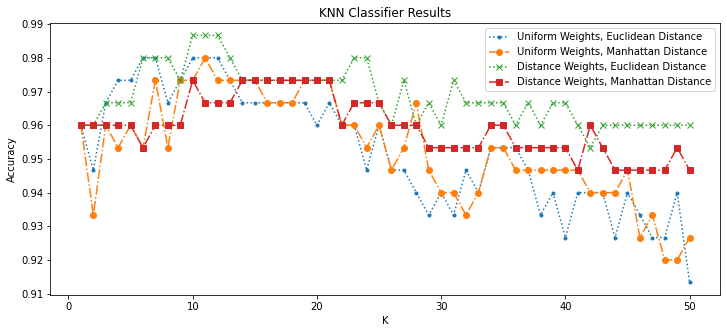

In [17]:
plt.figure(figsize=(12, 5))

mask = (grid.cv_results_['param_weights'] == 'uniform') & (grid.cv_results_['param_metric'] == 'euclidean')
k_vals = grid.cv_results_['param_n_neighbors'][mask].data
acc_vals = grid.cv_results_['mean_test_score'][mask]
plt.plot(k_vals, acc_vals, '.:', label='Uniform Weights, Euclidean Distance')

mask = (grid.cv_results_['param_weights'] == 'uniform') & (grid.cv_results_['param_metric'] == 'manhattan')
k_vals = grid.cv_results_['param_n_neighbors'][mask].data
acc_vals = grid.cv_results_['mean_test_score'][mask]
plt.plot(k_vals, acc_vals, 'o-.', label='Uniform Weights, Manhattan Distance')

mask = (grid.cv_results_['param_weights'] == 'distance') & (grid.cv_results_['param_metric'] == 'euclidean')
k_vals = grid.cv_results_['param_n_neighbors'][mask].data
acc_vals = grid.cv_results_['mean_test_score'][mask]
plt.plot(k_vals, acc_vals, 'x:', label='Distance Weights, Euclidean Distance')

mask = (grid.cv_results_['param_weights'] == 'distance') & (grid.cv_results_['param_metric'] == 'manhattan')
k_vals = grid.cv_results_['param_n_neighbors'][mask].data
acc_vals = grid.cv_results_['mean_test_score'][mask]
plt.plot(k_vals, acc_vals, 's-.', label='Distance Weights, Manhattan Distance')

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Results')
plt.legend()
plt.show()